### Research: how well the photodiode signal correlates with Ed values (interpolated to the Lu response time).

#### Terminology:

**Ed (Downwelling Irradiance)** represents the incoming radiant flux (radiant power) from all directions of the upper hemisphere onto a surface (e.g., the Earth's surface or an object). It includes all the incoming electromagnetic radiation, regardless of the direction. It characterizes the total radiant energy received by a surface.

**Lu (Upwelling Radiance)** characterizes the radiant energy that is reflected or emitted by the surface and travels upward.

**Ld (Downwelling Radiance).** Is a measure of the brightness of the radiation coming from the upper hemisphere towards a specific point on the surface. It provides information about the intensity and directionality of the incoming radiation.

Ed represents the incoming energy,
Ld represents the incoming energy's intensity and directionality, and
Lu represents the outgoing energy from the surface or object.

**Photodiodes** are often used to measure the intensity of light in lux. When light falls on a photodiode, it generates an electrical signal, the strength of which is proportional to the illuminance (lux) of the incident light.

**Photodiode Signal and Reflectance Spectrum.** A light source illuminates a material, and the photodiode measures the intensity of the reflected light at various wavelengths. The resulting photodiode signal is used to create a reflectance spectrum, which provides information about how the material reflects light across the visual spectrum. With the photodiode signal in lux and the photopic data, which typically includes the photopic luminous efficiency function V(λ) as a function of wavelength (λ), we can "weighting" the illuminance measurement to account for the human eye's sensitivity to different wavelengths. This calculation provides a way to convert the measured illuminance into a quantity that represents the perceived brightness of light at that specific wavelength. The result is known as "luminance" or "brightness" at that particular wavelength.

**Hypstar water transfer protocol.** 
Ed - Downwelling Irradiance; Ld - Downwelling Radiance; Lu - Upwelling Radiance
Transfer protocol: [Ed 3x] - [Ld 3x] - [Lu 6x] - [Ld 3x] - [Ed 3x]. Sequential measurements.

![](../data/photodiode/_img/chart2.jpg)

![](https://github.com/fjodorsevtsenko/rs-pr-water/blob/main/img/chart2.png)
<img src = '../../../../img/chart2.png' width=100%>

![](../data/photodiode/_img/chart.jpg)

<img src = '../../../../img/chart.png' width=100%>

#### Data available

**photopic.dat**: wavelength;V(lambda)
**monitorpd**: photodiode time series (lux of photometric units)
**L1A;L1B;L1C**
HYPERNETS_W_LVES_L1A_IRR: downwelling irradiance (Ed all six measurements)
HYPERNETS_W_LVES_L1B_IRR: downwelling irradiance (Ed0 and Ed1 averages)
HYPERNETS_W_LVES_L1C_ALL: downwelling irradiance; downwelling radiance; upwelling radiance

#### Task, simplified
<br>

1. Get photodiode signal.
2. Convert photodiode signal to Wavelength-Luminance/Brightness format.
3. Get Ed0 (start) and Ed1 (end) from L1B.
4. Calculate Ed0-Luminance ratio and Ed1-Luminance ratio for each common wavelength.
5. Adjust Ed0-Luminance ratio and Ed1-Luminance ratio to the same UTF.
6. Calculate Pearson correlation between Ed0-Luminance ratio and Ed1-Luminance ratio
7. Get scatter plots by wavelengths.

### Table of content

**[01]: Data preprocessing**

- [01-01]: Use the next terminal commands to copy 'monitorPD' and 'hypernets' data files into relevant folders
- [01-02]: Import libraries and set path-variables to files' locations
- [01-03]: Run extraction/transformation for 'monitorpd' data; Apply 'photopic' weighting; Save result in a 'parquet' format
- [01-04]: Read 'monitorpd' dataset from 'parquet' file
- [01-05]: Run extraction/transformation for 'hypernets' data- Ed0 and Ed1; Save result in a 'parquet' format
- [01-06]: Read 'hypernets' dataset from 'parquet' file

**[02]: Find intersection space between 'monitorpd' and 'hypernets' datasets by 'wavelength' and 'utf'**
- [02-01]: Get common by 'wavelength' and 'utf'
- [02-02]: Adjust 'monitorpd' dataset by common 'wavelength' and 'utf'
- [02-03]: Adjust 'hypernets' dataset by common 'wavelength' and 'utf'
- [02-04]: Save 'index-utf' combination
- [02-05]: Get Ed0-photodiode ratio and Ed1-photodiode ratio
- [02-06]: Adjust Ed0-photodiode ratio and Ed1-photodiode ratio to common shape

**[03]: Calculate correlations between photodiode signal (monitorpd) and Ed (hypernets) for each common wavelength**

**[04]: Plot the correlation between photodiode signal (monitorpd) and Ed (hypernets) by wavelength**


<br>
<hr>

#### [01]: Data preprocessing

##### [01-01]: Use the next terminal commands to copy 'monitorPD' and 'hypernets' data files into relevant folders

In [58]:
# _nc_files_HYPERNETS_W_LVES_L1B_IRR % find ../LVES -type f -name "HYPERNETS_W_LVES_L1B_IRR_*.nc" -exec cp {} . \;
# find ../DATA -type f -name "monitorPD.csv" -exec sh -c 'new_name="./$(basename "$(dirname "$0")").csv"; cp "$0" "$new_name"' {} \;

##### [01-02]: Import libraries and set path-variables to files' locations

In [1]:
import sys
sys.path.append('..\\models')
from helpers import _ltt000025_fsevts_photodiode_correlation as _ltt000025

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
from tqdm import tqdm


PATH_TO_DATA = "../data/photodiode/"
PATH_TO_EXPORT = "../data/photodiode/_export/"
PATH_TO_PHOTOPIC = f"{PATH_TO_DATA}photopic.dat"
PATH_TO_HYPERNETS_NC = f"{PATH_TO_DATA}_nc_HYPERNETS_W_LVES_L1B_IRR/"
PATH_TO_MONITORPD_CSV = f"{PATH_TO_DATA}_csv_MONITORPD/"

helper = _ltt000025.Helper()

In [60]:
def absoluteFilePaths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))

filepaths_csv = [p for p in absoluteFilePaths("../data/DATA")]
for filepath in tqdm(filepaths_csv):
    folder_name = filepath.split("\\")[-2]
    shutil.copy2(filepath, f"{PATH_TO_MONITORPD_CSV}{folder_name}.csv")


100%|██████████| 2597/2597 [00:04<00:00, 540.48it/s]


In [13]:
df_photopic = helper.read_photopic(PATH_TO_PHOTOPIC)

In [67]:
dfs_monitorpd = [helper.read_monitorpd(path) for path in helper.get_list_of_files(PATH_TO_MONITORPD_CSV)]
dfs_transformed = [helper.transform(df_photopic, df_) for df_ in dfs_monitorpd]
df_monitorpd_transformed = pd.concat(dfs_transformed, ignore_index=True)
df_monitorpd_transformed = df_monitorpd_transformed.sort_values(by='utf_', ascending=True)
df_monitorpd_transformed.to_parquet(f"{PATH_TO_EXPORT}_df_monitorpd_transformed.parquet", index=False)

In [14]:
df_monitorpd_transformed = pd.read_parquet(f"{PATH_TO_EXPORT}_df_monitorpd_transformed.parquet")
df_monitorpd_transformed.head(3)

,utf_,380,385,390,395,400,405,410,415,420,...,735,740,745,750,755,760,765,770,775,780
0,1689915635,0.248028,0.125267,0.062007,0.032004,0.017716,0.010645,0.006703,0.004204,0.002835,...,0.137412,0.199219,0.288405,0.413380,0.584972,0.826761,1.169944,1.653521,2.339888,3.307042
1,1689915636,0.248252,0.125380,0.062063,0.032033,0.017732,0.010655,0.006710,0.004208,0.002837,...,0.137536,0.199399,0.288665,0.413754,0.585501,0.827508,1.171001,1.655015,2.342003,3.310031
2,1689915638,0.248242,0.125375,0.062061,0.032031,0.017732,0.010654,0.006709,0.004207,0.002837,...,0.137530,0.199392,0.288654,0.413737,0.585477,0.827475,1.170955,1.654950,2.341910,3.309899


In [77]:
# Ed beginning phase
filepaths_nc = [p for p in absoluteFilePaths("../data/LVES") if "L1B" in p]

dfs_transformed_nc = [helper.get_nc_transformed_0(path) for path in filepaths_nc]
df_nc_transform_0 = pd.concat(dfs_transformed_nc, ignore_index=True)
df_nc_transform_0 = df_nc_transform_0.sort_values(by='utf_', ascending=True)
df_nc_transform_0.to_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_0.parquet", index=False)

In [78]:
dfs_transformed_nc = [helper.get_nc_transformed_1(path) for path in filepaths_nc]
df_nc_transform_1 = pd.concat(dfs_transformed_nc, ignore_index=True)
df_nc_transform_1 = df_nc_transform_1.sort_values(by='utf_', ascending=True)
df_nc_transform_1.to_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_1.parquet", index=False)

In [5]:
df_nc_transform_0 = pd.read_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_0.parquet")
df_nc_transform_0.head(3)

,utf_,350,351,352,353,354,355,356,357,358,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,1689915676,139.896606,145.060913,149.192886,152.974747,164.423500,163.010925,156.661385,145.117345,138.356697,...,149.501770,154.458481,146.774132,140.697375,128.467457,123.450153,130.477936,124.133533,121.280273,148.973389
1,1689916575,161.907890,168.990608,170.145760,176.260399,187.366058,188.746529,180.372185,166.402359,157.716202,...,169.179604,174.959175,174.539085,156.256490,178.930298,164.121323,153.947281,146.457596,143.814651,141.991196
2,1689917475,177.386772,181.828560,185.042961,189.548058,203.414146,205.429596,195.282272,176.238749,169.310211,...,189.879265,177.713013,173.848686,162.848836,155.844643,170.411537,152.039856,161.167267,165.148636,154.165115


In [6]:
df_nc_transform_1 = pd.read_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_1.parquet")
df_nc_transform_1.head(3)

,utf_,350,351,352,353,354,355,356,357,358,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,1689915754,142.550522,147.574211,150.712372,154.669807,164.871346,166.075813,158.392525,144.982076,137.421059,...,151.593727,156.967537,140.197639,141.519674,145.308426,145.080521,143.925034,143.351284,125.748226,136.977936
1,1689916652,163.663124,168.368553,171.821381,175.707245,187.733711,190.072006,180.430077,165.348012,156.123352,...,188.054024,173.735954,182.840248,163.104975,164.546234,173.787094,162.730103,169.695465,144.259354,165.980408
2,1689917550,177.708466,183.056145,186.081207,191.546562,205.449745,203.993362,196.628700,179.525533,170.985229,...,205.970612,187.659409,175.906380,181.345225,175.194138,176.251663,167.392502,168.803024,155.513329,156.134140


<Axes: >

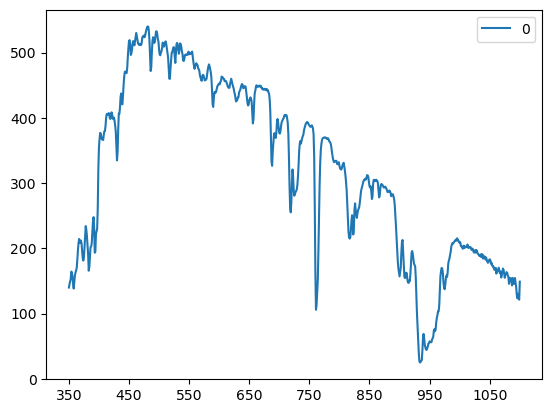

In [7]:
df_nc_transform_0.head(1).T.iloc[1:].plot()

<Axes: >

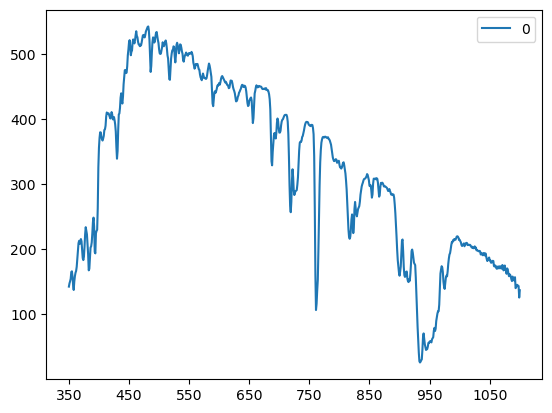

In [8]:
df_nc_transform_1.head(1).T.iloc[1:].plot()

<Axes: >

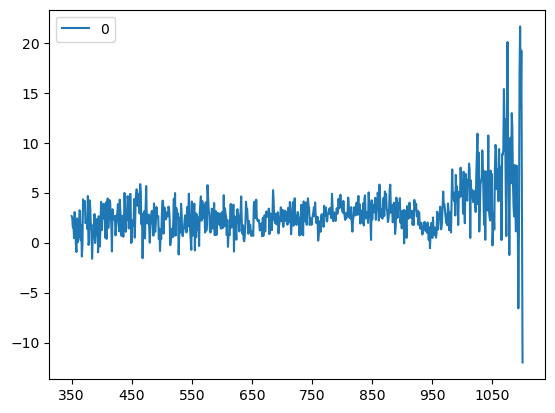

In [9]:
(df_nc_transform_1.head(1).T.iloc[1:]-df_nc_transform_0.head(1).T.iloc[1:]).plot()

<Axes: >

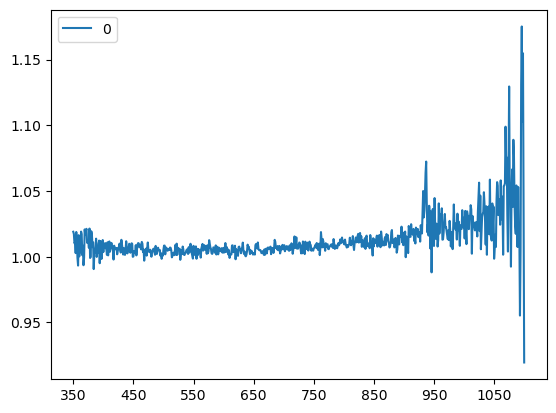

In [10]:
(df_nc_transform_1.head(1).T.iloc[1:]/df_nc_transform_0.head(1).T.iloc[1:]).plot()

In [15]:
s_lambda_over_wl = df_photopic.set_index("wl_")["v_lambda_"]

<Axes: xlabel='wl_'>

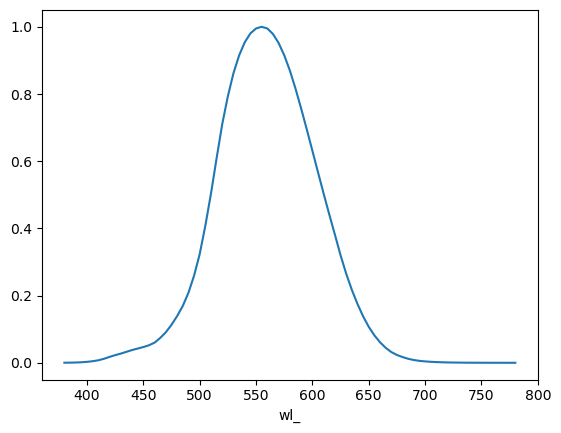

In [16]:
s_lambda_over_wl.plot()

In [17]:
wavelen_cols = df_photopic.wl_.astype(str).tolist()

In [18]:
df_nc_transform_0[wavelen_cols].head(3)

,380,385,390,395,400,405,410,415,420,425,...,735,740,745,750,755,760,765,770,775,780
0,218.692352,187.254875,241.101723,221.921654,354.718536,366.969650,379.941925,405.752502,402.382233,400.438049,...,364.589508,374.329987,392.344986,388.169724,386.807556,160.905640,194.784157,360.137985,369.676575,368.737518
1,255.541183,217.085236,279.554337,259.224503,412.977432,426.690231,443.097036,473.159744,475.641449,467.612854,...,430.429977,442.860214,462.041382,456.459671,454.767532,192.527191,236.566612,425.201782,435.038330,432.012787
2,272.309448,232.281143,299.763565,277.359055,440.061523,455.407104,471.313141,501.046555,500.387848,492.915161,...,444.098206,453.806183,473.084793,465.579346,463.837387,200.253380,246.603973,434.761475,443.912643,443.069946


<Axes: >

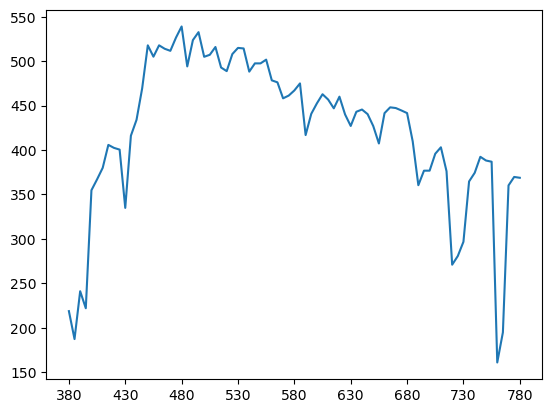

In [19]:
df_nc_transform_0[wavelen_cols].iloc[0].T.plot()

In [20]:
s_lambda_over_wl

wl_
380    0.000200
385    0.000396
390    0.000800
395    0.001550
400    0.002800
         ...   
760    0.000060
765    0.000042
770    0.000030
775    0.000021
780    0.000015
Name: v_lambda_, Length: 81, dtype: float64

In [21]:
common_utf_0 = set(df_monitorpd_transformed['utf_']).intersection(set(df_nc_transform_0['utf_']))
common_utf_1 = set(df_monitorpd_transformed['utf_']).intersection(set(df_nc_transform_1['utf_']))
print(f"Common utf_ 0: {len(common_utf_0)}")
print(f"Common utf_ 1: {len(common_utf_1)}")
common_utf = common_utf_0 | common_utf_1
print(f"Common utf_: {len(common_utf)}")

Common utf_ 0: 1757
Common utf_ 1: 1746
Common utf_: 3503


In [22]:
df_nc_transform_1.utf_


0       1689915754
1       1689916652
2       1689917550
3       1689918452
4       1689919350
           ...    
1768    1696493867
1769    1696494769
1770    1696495666
1771    1696496568
1772    1696497465
Name: utf_, Length: 1773, dtype: int64

In [65]:
s_tr_0_weighted_sum = pd.DataFrame((df_nc_transform_0[wavelen_cols] * s_lambda_over_wl.to_numpy()).sum(axis=1))

In [66]:
s_tr_1_weighted_sum = pd.DataFrame((df_nc_transform_1[wavelen_cols] * s_lambda_over_wl.to_numpy()).sum(axis=1))

In [103]:
df_nc_transform_0["timestamp"] = (df_nc_transform_0["utf_"]*1_000_000_000).apply(pd.Timestamp)
df_nc_transform_1["timestamp"] = (df_nc_transform_1["utf_"]*1_000_000_000).apply(pd.Timestamp)

s_tr_0_weighted_sum["t_s"] = df_nc_transform_0["utf_"] - df_nc_transform_0["utf_"].min()
s_tr_1_weighted_sum["t_s"] = df_nc_transform_1["utf_"] - df_nc_transform_0["utf_"].min()

In [104]:
s_tr_0_weighted_sum["1_2_frac"] = s_tr_1_weighted_sum[0] / s_tr_0_weighted_sum[0]
s_tr_0_weighted_sum["t_days"] = s_tr_1_weighted_sum["t_s"] / (3600*24)
s_tr_0_weighted_sum["timestamp_from"] = df_nc_transform_0["timestamp"]
s_tr_0_weighted_sum["timestamp_to"] = df_nc_transform_1["timestamp"]

### How much is the Ed1/Ed0 frac affected by the season?

[None]

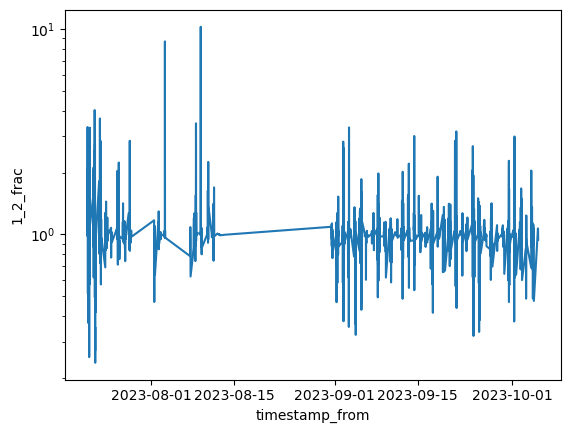

In [105]:
from matplotlib import pyplot as plt
import seaborn as sns
lines = sns.lineplot(data=s_tr_0_weighted_sum, x="timestamp_from", y="1_2_frac")
lines.set(yscale='log')

#s_tr_0_weighted_sum[["t_s", "1_2_frac"]].plot()

### Visible Ed1/Ed0 frac decrease in later hours.
This makes sense, as the later measurement is done in slightly lower light conditions in the 2nd half of the day.

<Axes: xlabel='timestamp_to'>

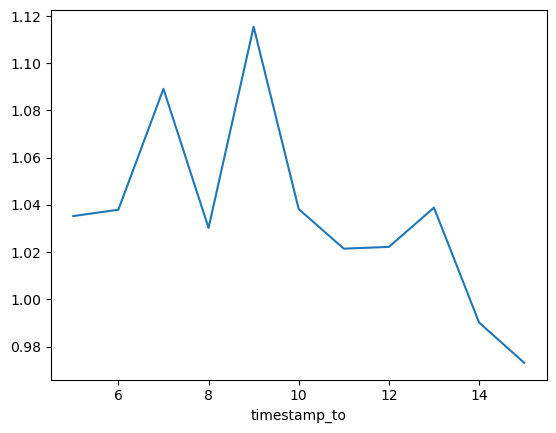

In [146]:
s_tr_0_weighted_sum.groupby(s_tr_0_weighted_sum["timestamp_to"].dt.hour).mean("1_2_frac")["1_2_frac"].plot()

In [107]:
s_tr_0_weighted_sum["timestamp_diff"] = s_tr_0_weighted_sum["timestamp_to"] - s_tr_0_weighted_sum["timestamp_from"]

In [118]:
s_tr_0_weighted_sum["timestamp_diff_s"] = s_tr_0_weighted_sum["timestamp_diff"].dt.total_seconds()

[None]

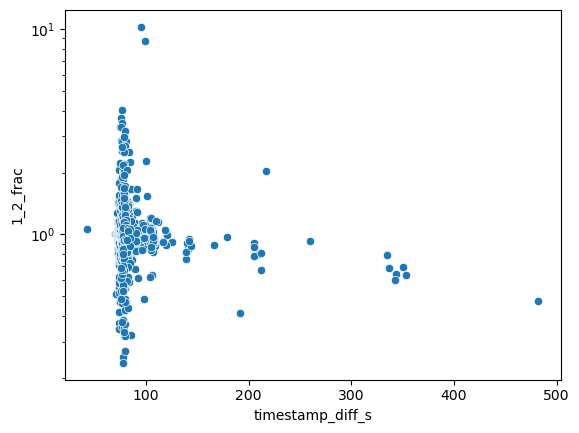

In [120]:
points = sns.scatterplot(s_tr_0_weighted_sum, x="timestamp_diff_s", y="1_2_frac")
points.set(yscale='log')


[None, None]

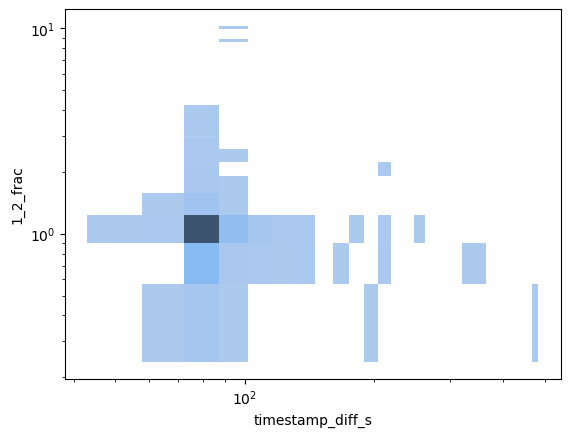

In [132]:
hist = sns.histplot(s_tr_0_weighted_sum, x="timestamp_diff_s", y="1_2_frac", bins=30, thresh=0)
hist.set(yscale='log', xscale='log')